In [2]:
from simple_mp.simple import simple_fast

In [49]:
from pathlib import Path
import numpy as np
import IPython.display as ipd
import librosa

root = Path("../data")
motif = root / "motif/train_short_audio/acafly"

data = []
species = []
audio = []
for path in motif.glob("**/motif.cens.*.npy"):
    data.append(np.load(path))
    species.append(path.parent.parent.name)
    audio.append(path.as_posix().replace(".cens", "").replace(".npy", ".ogg"))

Let's compare the first 20 acafly sounds against the 20 osprey sounds, self and not.

In [76]:
simple = [simple_fast(data[0], data[i], 10) for i in range(len(data))]
medians = [np.median(mp) for mp, _ in simple]
mins = [np.min(mp) for mp, _ in simple]
medians[:10], mins[:10]

([0.015532458717827602,
  0.04345576206079316,
  1.6123131555922248,
  1.5539070312045302,
  0.320058138147137,
  0.32315028682211544,
  0.6445230252040852,
  0.5480925531328433,
  0.20222557713432554,
  0.2738109816949772],
 [0.010377043134552233,
  0.002012847133645357,
  1.3499536877266247,
  1.3544182888543803,
  0.14142410695152985,
  0.18711659789515145,
  0.4577013663930378,
  0.3514778693521101,
  0.11467747282901586,
  0.18556538062927053])

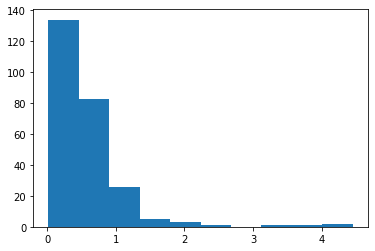

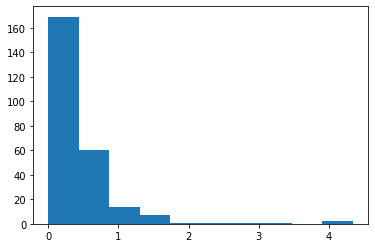

In [79]:
from matplotlib import pyplot as plt

plt.hist(medians)
plt.show()
plt.hist(mins)
plt.show()

## audio tracks by distance (median)

In [80]:
# could be better...
res = sorted([(m,i) for i,m in enumerate(medians)])
print("closest (median)")
for v, i in res[:5]:
    print(f"motif {i} with score {v}: {audio[i]}")
    ipd.display(ipd.Audio(audio[i]))

closest (median)
motif 0 with score 0.015532458717827602: ../data/motif/train_short_audio/acafly/XC109605/motif.0.ogg


motif 1 with score 0.04345576206079316: ../data/motif/train_short_audio/acafly/XC109605/motif.1.ogg


motif 18 with score 0.04973378939285533: ../data/motif/train_short_audio/acafly/XC131193/motif.0.ogg


motif 19 with score 0.06106078071031584: ../data/motif/train_short_audio/acafly/XC131193/motif.1.ogg


motif 33 with score 0.06467912914635465: ../data/motif/train_short_audio/acafly/XC137858/motif.1.ogg


In [81]:
print("furthest (median)")
for v, i in res[-5:]:
    print(f"motif {i} with score {v}: {audio[i]}")
    ipd.display(ipd.Audio(audio[i]))

furthest (median)
motif 158 with score 2.406102437630821: ../data/motif/train_short_audio/acafly/XC370169/motif.0.ogg


motif 111 with score 3.227279160903673: ../data/motif/train_short_audio/acafly/XC31063/motif.1.ogg


motif 110 with score 3.7044397475598876: ../data/motif/train_short_audio/acafly/XC31063/motif.0.ogg


motif 153 with score 4.167199232008783: ../data/motif/train_short_audio/acafly/XC354274/motif.1.ogg


motif 152 with score 4.4546979550393875: ../data/motif/train_short_audio/acafly/XC354274/motif.0.ogg


## audio tracks by distance (min)

In [82]:
res = sorted([(m,i) for i,m in enumerate(mins)])
print("closest (min)")
for v, i in res[:5]:
    print(f"motif {i} with score {v}: {audio[i]}")
    ipd.display(ipd.Audio(audio[i]))

closest (min)
motif 1 with score 0.002012847133645357: ../data/motif/train_short_audio/acafly/XC109605/motif.1.ogg


motif 0 with score 0.010377043134552233: ../data/motif/train_short_audio/acafly/XC109605/motif.0.ogg


motif 39 with score 0.02760242807476021: ../data/motif/train_short_audio/acafly/XC138091/motif.1.ogg


motif 19 with score 0.03113095538477406: ../data/motif/train_short_audio/acafly/XC131193/motif.1.ogg


motif 18 with score 0.031130955384775394: ../data/motif/train_short_audio/acafly/XC131193/motif.0.ogg


In [83]:
print("furthest (min)")
for v, i in res[-5:]:
    print(f"motif {i} with score {v}: {audio[i]}")
    ipd.display(ipd.Audio(audio[i]))

furthest (min)
motif 158 with score 2.172901833714729: ../data/motif/train_short_audio/acafly/XC370169/motif.0.ogg


motif 111 with score 2.9502982236080317: ../data/motif/train_short_audio/acafly/XC31063/motif.1.ogg


motif 110 with score 3.416576009702971: ../data/motif/train_short_audio/acafly/XC31063/motif.0.ogg


motif 153 with score 4.053668017999457: ../data/motif/train_short_audio/acafly/XC354274/motif.1.ogg


motif 152 with score 4.341295624515344: ../data/motif/train_short_audio/acafly/XC354274/motif.0.ogg


## audio track embedding

Setting a window of 10 (1 second) leads to questionable results on the median.
Seeting a window of 30 (3 seconds) leads to better results near the cluster centers. The plot is a little more spread out, and the computation is much faster.
Seeting a window of 40 leads to more questionable results. Sigh, I guess these need to be used to find more examples

In [124]:
from tqdm import tqdm

n = len(data)
affinity = np.zeros((n, n))

for i in tqdm(range(n)):
    for j in range(i, n):
        mp, _ = simple_fast(data[i], data[j], 25)
        val = np.median(mp)
        affinity[i][j] = val
        affinity[j][i] = val

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [02:58<00:00,  1.43it/s]


In [125]:
from sklearn.manifold import spectral_embedding

emb = spectral_embedding(affinity)
emb.shape

(256, 8)

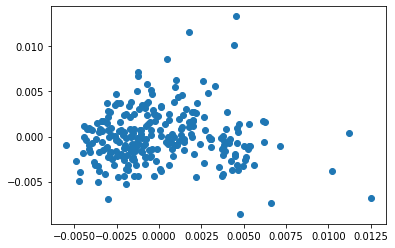

In [126]:
plt.scatter(emb[:, 0], emb[:, 1])

In [127]:
from sklearn.cluster import k_means

centroid, label, _ = k_means(emb, 3)

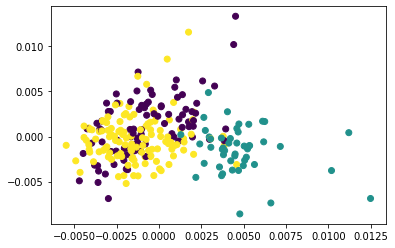

In [128]:
plt.scatter(emb[:, 0], emb[:, 1], c=label)

In [129]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors().fit(emb)

dist, neighbors = nn.kneighbors(centroid)
neighbors, label[neighbors]

(array([[157,  32, 142, 236, 149],
        [227, 244, 225, 210, 218],
        [138,  70,  67,  97,  64]], dtype=int64),
 array([[0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2]]))

In [130]:
for row in neighbors:
    print(f"# label {label[row[0]]}")
    for ex in row:
        print(f"{ex} {audio[ex]}")
        ipd.display(ipd.Audio(audio[ex]))

# label 0
157 ../data/motif/train_short_audio/acafly/XC358865/motif.1.ogg


32 ../data/motif/train_short_audio/acafly/XC137858/motif.0.ogg


142 ../data/motif/train_short_audio/acafly/XC328245/motif.0.ogg


236 ../data/motif/train_short_audio/acafly/XC548848/motif.0.ogg


149 ../data/motif/train_short_audio/acafly/XC342677/motif.1.ogg


# label 1
227 ../data/motif/train_short_audio/acafly/XC517939/motif.1.ogg


244 ../data/motif/train_short_audio/acafly/XC579060/motif.0.ogg


225 ../data/motif/train_short_audio/acafly/XC51409/motif.1.ogg


210 ../data/motif/train_short_audio/acafly/XC476751/motif.0.ogg


218 ../data/motif/train_short_audio/acafly/XC493597/motif.0.ogg


# label 2
138 ../data/motif/train_short_audio/acafly/XC324931/motif.0.ogg


70 ../data/motif/train_short_audio/acafly/XC247271/motif.0.ogg


67 ../data/motif/train_short_audio/acafly/XC244719/motif.1.ogg


97 ../data/motif/train_short_audio/acafly/XC265805/motif.1.ogg


64 ../data/motif/train_short_audio/acafly/XC240101/motif.0.ogg
